# Before you use this notebook

## Disable Data Execution Prevention - DEP
1. Type cmd in the start search menu, **right-click** on it and select **Run as Administrator**.
2. Once the command prompt is open, you can now disable [Data Execution Prevention](https://pt.wikipedia.org/wiki/Data_Execution_Prevention) (DEP) by entering the following command line.
        bcdedit.exe /set nx AlwaysOff
3. And to enable it back,
        bcdedit.exe /set nx AlwaysOn

## Conda env config

Download [miniconda](https://conda.io/miniconda.html) (python 3.X - 64bit):

    set CONDA_FORCE_32BIT=1
    conda create -n py3_32bit python=3 numpy matplotlib seaborn pandas
    activate py3_32bit

**NOTE**: Always remember to `set CONDA_FORCE_32BIT=1` before activating env.

In [1]:
import os
from ctypes import *
os.environ["PATH"] += 'bin'
pat_flow = windll.LoadLibrary('PatFlow.dll')

In [2]:
import numpy as np

def calculate_flow_pattern_transition(ρ, μ, σ, D, θ, k_s, interface, Nt=6, n=40, nc=5, Tr=None, E_Tr=None):
    """
    Nt = 6  # Number of Transition
    n  = 40 # Number of points
    nc = 5  # Number of cicles
    
    """
    prop = [ρ[0], μ[0], σ, ρ[1], μ[1], D, θ, k_s, interface]
    
    # Output Variables
    if Tr is None:
        Tr   = np.zeros((n*nc, Nt*2), dtype=np.float64) # Transition Matrix
        Tr   = np.asfortranarray(Tr) # This is important!
    if E_Tr is None:
        E_Tr = np.ones((n*nc, Nt  ), dtype=np.int)      # Error Matrix 
        E_Tr = np.asfortranarray(E_Tr) # This is important!
    
    time = c_double(0.0)

    # Call PATFLOW(Prop(1), n, nc, Nt, Tr(1, 1), ETr(1, 1), Time)
    pat_flow.PATFLOW(
        np.asarray(prop).ctypes.data_as(POINTER(c_double)), 
        byref(c_int(n )), 
        byref(c_int(nc)), 
        byref(c_int(Nt)), 
        Tr.ctypes.data_as(POINTER(c_double)), 
        E_Tr.ctypes.data_as(POINTER(c_int)), 
        byref(time)
    )
    
    return Tr, E_Tr

In [3]:
def calculate_flow_pattern(U_SL, U_SG, ρ, μ, σ, D, θ, k_s, interface):
    prop = [ρ[0], μ[0], σ, ρ[1], μ[1], D, θ, k_s, interface]

    FPPredAux = c_int()
    IERR      = c_int()

    # Call GLFPPRED(Prop(1), VsL, VsG, FPPredAux, IERR)
    pat_flow.GLFPPRED(
        np.asarray(prop).ctypes.data_as(POINTER(c_double)),
        byref(c_double(U_SL)), 
        byref(c_double(U_SG)), 
        byref(FPPredAux), 
        byref(IERR)
    )
    FPPred = {1: 'SS',
              2: 'SW',
              3:  'A',
              4: 'DB',
              5:  'B',
              6: 'SL',}

    return FPPredAux.value, FPPred[FPPredAux.value], IERR.value

In [4]:
import seaborn
import matplotlib.pyplot as plt
import matplotlib
from buttons import *
from ipywidgets import interact

Nt=6
n=40
nc=5
Tr   = np.zeros((n*nc, Nt*2), dtype=np.float64) # Transition Matrix
Tr   = np.asfortranarray(Tr) # This is important!
E_Tr = np.ones((n*nc, Nt  ), dtype=np.int)      # Error Matrix 
E_Tr = np.asfortranarray(E_Tr) # This is important!


@interact(
    # Density
    ρ_L=ρ_L_button,   
    ρ_G=ρ_G_button,    
    # Viscosity
    μ_L=μ_L_button,
    μ_G=μ_G_button,    
    # Surface Tension
    σ=σ_button,    
    # Pipe Diameter
    D=D_button,    
    # Pipe Inclination
    θ=θ_button,
    # Pipe Roughness
    k_s=k_s_button,    
    interface=interface_button,
    plot_mesh=plot_mesh_button
)
def plot_transition_points(ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, interface, plot_mesh=False):
    fig = plt.figure(figsize=(10,10))
    plt.clf()
    plt.title('Flow Pattern Map', fontsize='x-large')

    labels = ['Stratified, Non-Stratified Flow',
              'Annular Flow',
              'Stratified Smooth-Wavy Flow',
              'Dispersed Bubble Flow',
              'Bubble Flow', 'Other']

    plt.grid(b=True, which='both', color='w')
    plt.axis('equal')

    plt.ylim((1e-3,100))
    plt.xlim((1e-3,100))
    plt.xlabel('$U_{SG}$', fontsize='x-large')
    plt.ylabel('$U_{SL}$', fontsize='x-large')

    
    ρ   = [ρ_L, ρ_G]
    μ   = [μ_L, μ_G]
    θ = np.deg2rad(θ) # [rad]

    transition_points, error_matrix = calculate_flow_pattern_transition(ρ, μ, σ, D, θ, k_s, interface, Tr=Tr, E_Tr=E_Tr)

    for i in range(error_matrix.shape[1]):
        x = transition_points[error_matrix[:, i] == 0, 2*i  ]
        y = transition_points[error_matrix[:, i] == 0, 2*i+1]
        plt.loglog(x, y, label=labels[i])

    if plot_mesh == 'True':
        nx, ny = 50, 50
        x = np.logspace(-3, 2, num=nx)
        y = np.logspace(-3, 2, num=ny)

        xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')
        flow_pattern = np.zeros_like(xv, dtype=int)
        for i in range(nx):
            for j in range(ny):
                U_SL = xv[i,j]
                U_SG = yv[i,j]

                idx, fp, ierr = calculate_flow_pattern(U_SL, U_SG, ρ, μ, σ, D, θ, k_s, interface)
                flow_pattern[i,j] = idx
            
        norm = matplotlib.colors.Normalize(vmin=0,vmax=5)

        plt.scatter(yv.flatten(), 
                    xv.flatten(), 
                    c=flow_pattern.flatten(), 
                    cmap=plt.get_cmap('Set1'), 
                    norm=norm)

    plt.legend(facecolor='w', fontsize='x-large')

    plt.show()

In [5]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

@interact(
    # Density
    ρ_L=ρ_L_button,   
    ρ_G=ρ_G_button,    
    # Viscosity
    μ_L=μ_L_button,
    μ_G=μ_G_button,    
    # Surface Tension
    σ=σ_button,    
    # Pipe Diameter
    D=D_button,    
    # Pipe Inclination
    θ=θ_button,
    # Pipe Roughness
    k_s=k_s_button,    
    interface=interface_button
)
def plotly_transition_points(ρ_L, ρ_G, μ_L, μ_G, σ, D, θ, k_s, interface):
    labels = ['Stratified, Non-Stratified Flow',
              'Annular Flow',
              'Stratified Smooth-Wavy Flow',
              'Dispersed Bubble Flow',
              'Bubble Flow', 'Other']

    ρ   = [ρ_L, ρ_G]
    μ   = [μ_L, μ_G]
    θ = np.deg2rad(θ) # [rad]

    transition_points, error_matrix = calculate_flow_pattern_transition(ρ, μ, σ, D, θ, k_s, interface, Tr=Tr, E_Tr=E_Tr)

    data = []
    for i in range(error_matrix.shape[1]):
        x = transition_points[error_matrix[:, i] == 0, 2*i  ]
        y = transition_points[error_matrix[:, i] == 0, 2*i+1]       
        trace = go.Scatter(x=x, y=y, name=labels[i])
        data.append(trace)

    layout = go.Layout(
        title='Flow Pattern Map',
        width=800,
        height=650,
        showlegend=True,
        legend=dict(orientation="v"),
        xaxis=dict(
            title='Gas Superficial Velocity [m/s]',
            type='log',
            range=(-3, 2),
            autotick=False,
        ),
        yaxis=dict(
            title='Liquid Superficial Velocity [m/s]',
            type='log',
            range=(-3, 2),
            autotick=False,
        )
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

# Static Example

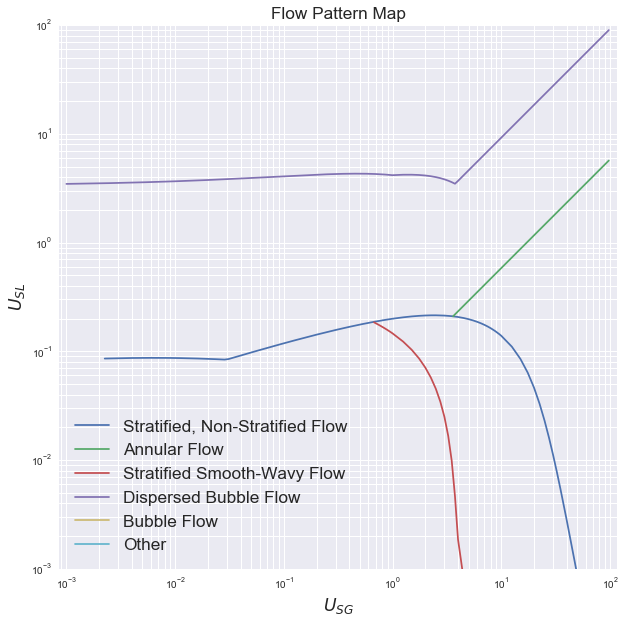

In [6]:
plot_transition_points(ρ_L=1000, ρ_G=2, μ_L=1e-3, μ_G=1e-5, σ=0.07, D=0.1, θ=0, k_s=0, interface=1)

## APPENDIX

### Some info about `PatFlow.dll`:
```
Dump of file PatFlow.dll
File Type: DLL
  Section contains the following exports for PatFlow.dll
    ordinal hint RVA      name
          1    0 00008A3B GLFPPRED
          3    1 000082D4 HLD
          5    2 00008439 HLDUP
          7    3 00007F78 PATFLOW
          9    4 0000859E VSGHLDCNT
         11    5 00008703 VSGVLCNT
         13    6 0000889F VSGVLCNTUP
          2    7 00008A3B _GLFPPRED@20
          4    8 000082D4 _HLD@20
          6    9 00008439 _HLDUP@20
          8    A 00007F78 _PATFLOW@28
         10    B 0000859E _VSGHLDCNT@20
         12    C 00008703 _VSGVLCNT@20
         14    D 0000889F _VSGVLCNTUP@20
```